In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import matplotlib.ticker as ticker
import matplotlib.patches as patches

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib

import polars as pl
pl.Config.set_tbl_rows(-1);
pl.Config.set_fmt_str_lengths(50);


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Read centromeres

In [4]:
cent_df = (
    pl.read_csv(
        "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/03.t2t-chm13/chm13v2.0_cytobands_allchrs.bed",
        separator="\t",
        has_header=False,
        new_columns=["chrom", "start", "end", "name", "type"],
    )
    .filter(pl.col("chrom").is_in(aut_chrom_names))
    .filter(pl.col("type") == "acen")
    .group_by("chrom")
    .agg(
        pl.col("start").min(),
        pl.col("end").max(),
    )
    .sort("chrom")
)

In [5]:
cent_dict = {}
for chrom, start, end in cent_df.rows():
    cent_dict[chrom] = (start, end)

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [6]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]

CPU times: user 257 ms, sys: 315 ms, total: 572 ms
Wall time: 16.4 s


## Subset of reads 

In [7]:
%%time
dense_reads_with_detection_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        "T2T_reference_start",
        "T2T_reference_end",
        "high_quality_classification_class",
        "high_quality_classification_in_detectable_class",
    )                  
    .filter(pl.col("high_quality_classification_class").is_not_null())
    .collect()
)

CPU times: user 47.9 s, sys: 17.9 s, total: 1min 5s
Wall time: 1min 2s


# Draw

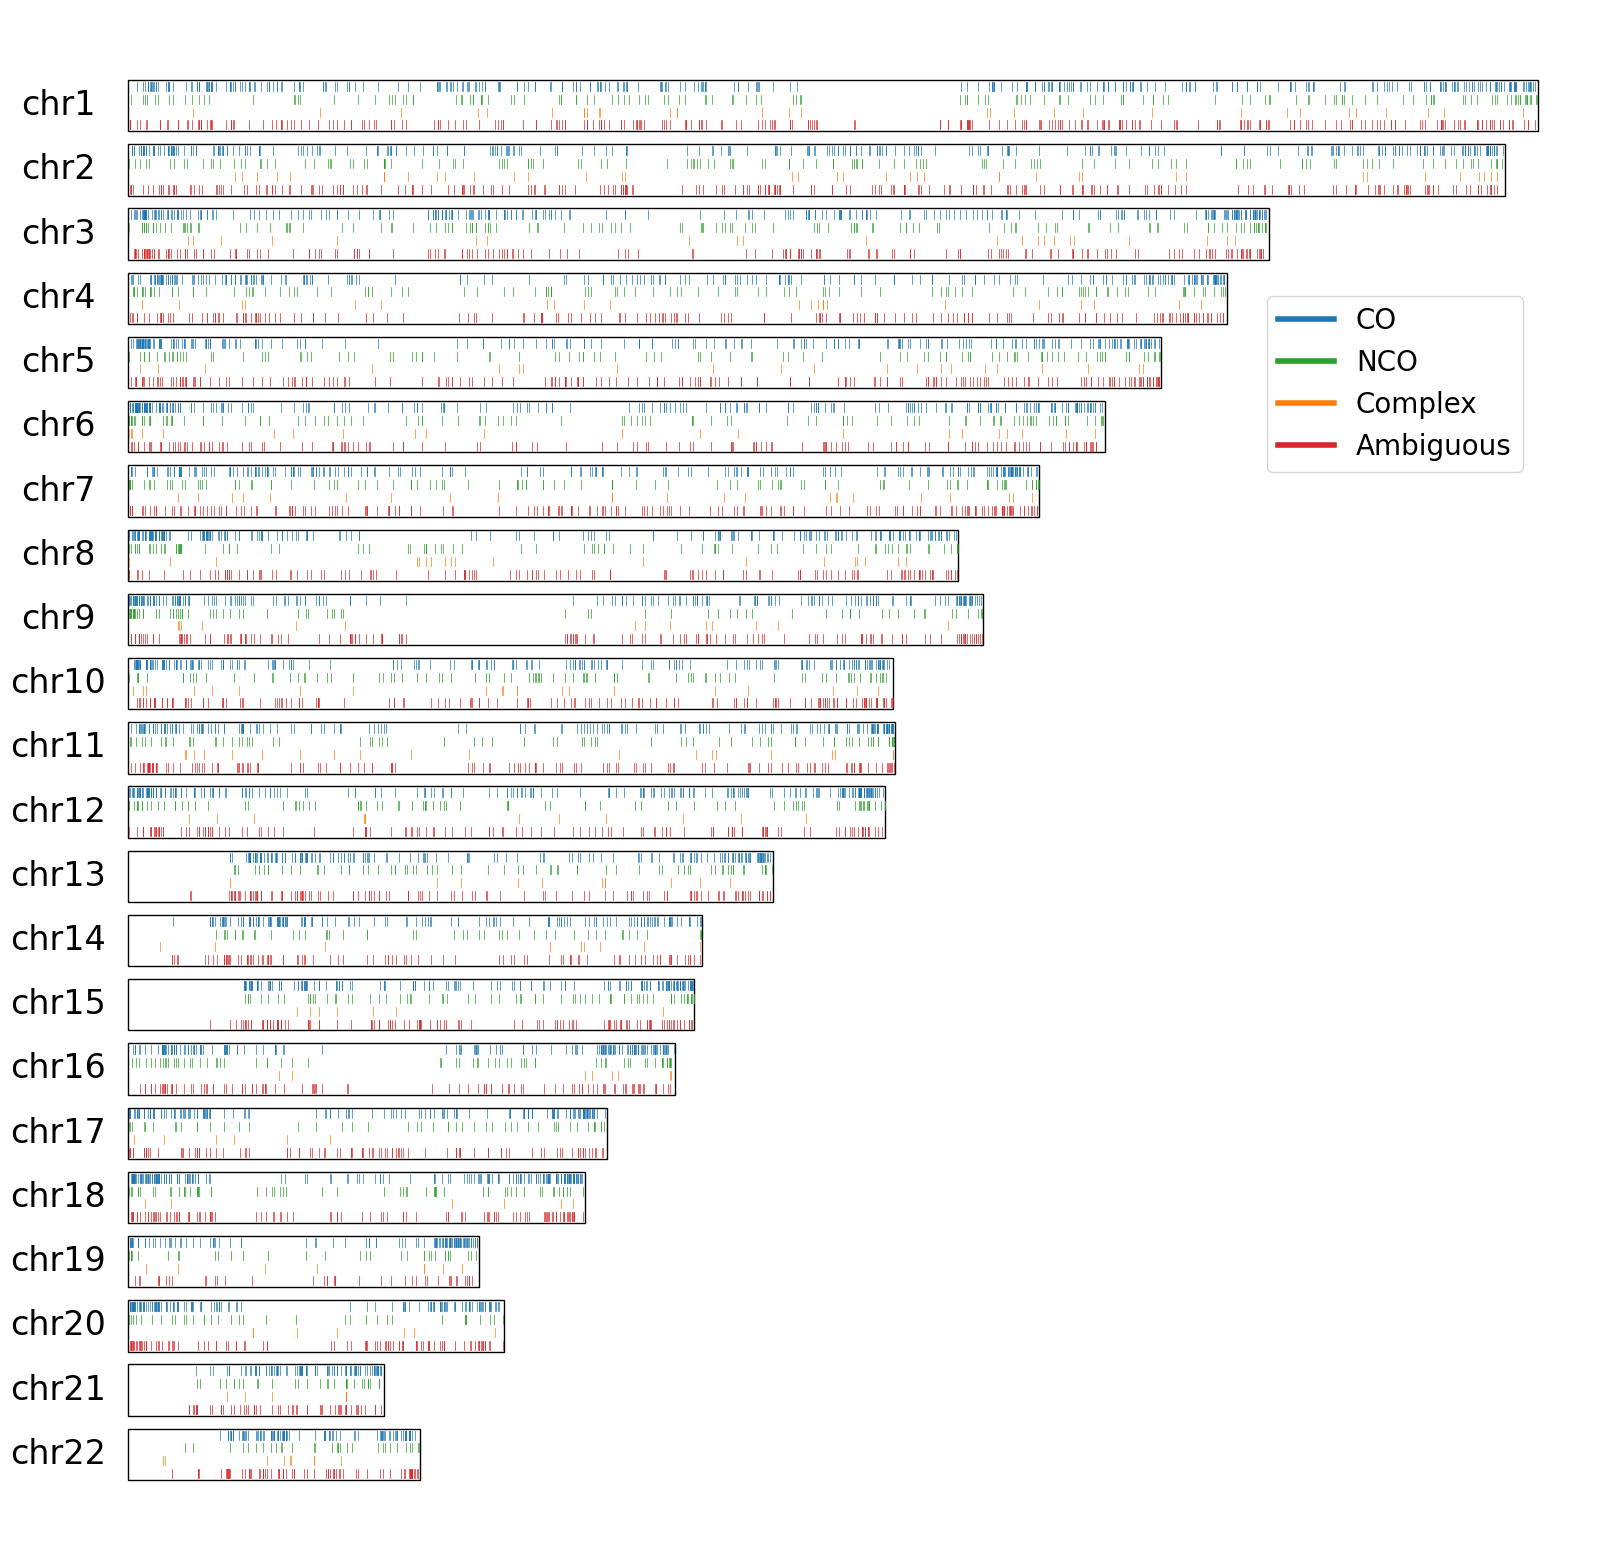

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the chromosome frames
max_chrom_len = liftover.T2T_chromosome_sizes_in_bp[aut_chrom_names[0]]
for n_chrom, chrom in enumerate(aut_chrom_names):
    chrom_len = liftover.T2T_chromosome_sizes_in_bp[chrom] / max_chrom_len
    
    patch = patches.Rectangle(
        (0, n_chrom), 
        chrom_len, 
        0.8, 
        linewidth=1, 
        edgecolor='black', 
        facecolor='none',
    )
    
    ax.add_patch(patch)
    
#     patch = patches.Rectangle(
#         (0 + cent_dict[chrom][0] / max_chrom_len, n_chrom), 
#         (cent_dict[chrom][1] - cent_dict[chrom][0]) / max_chrom_len, 
#         0.8, 
#         linewidth=2, 
#         edgecolor='black', 
#         facecolor='lightgray',
#     )
    
#     ax.add_patch(patch)
    
    ax.text(
        -0.05, 
        n_chrom+0.4, 
        chrom, 
        horizontalalignment='center', 
        verticalalignment='center',
        fontsize=24,
    )#, transform=ax.transAxes)
    
y_pad = 0.2
x_pad = 0.2
#ax.set_ylim(-y_pad, len(aut_chrom_names) + y_pad)
#ax.set_xlim(-x_pad, 1 + x_pad)
ax.invert_yaxis()

ax.spines[:].set_visible(False);
ax.set_xticks([]);
ax.set_yticks([]);

# Add the events
event_slack = 0.03
event_offset = 0.2
lw = 0.5
for n_chrom, chrom in enumerate(aut_chrom_names):
    df = (dense_reads_with_detection_df
        .filter(pl.col("chrom") == chrom)
        .filter(pl.col("T2T_reference_start").is_not_null())
    )
    
    # COs
    for row in df.filter(pl.col("high_quality_classification_class") == "CO").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_co, = ax.plot(
            [pos, pos], 
            [n_chrom+event_slack, n_chrom+event_offset-event_slack], 
            color=CO_color,
            lw=lw,
            label="CO",
        );
        
    # NCOs
    for row in df.filter(pl.col("high_quality_classification_class") == "GC").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_nco, = ax.plot(
            [pos, pos], 
            [n_chrom+event_offset+event_slack, n_chrom+event_offset*2-event_slack], 
            color=NCO_color,
            lw=lw,
            label="NCO",
        );
        
    # Complex
    for row in df.filter(pl.col("high_quality_classification_class") == "CNCO").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_complex, = ax.plot(
            [pos, pos], 
            [n_chrom+2*event_offset+event_slack, n_chrom+event_offset*3-event_slack], 
            color=complex_color,
            lw=lw,
            label="Complex",
        );
        
    # Ambiguous
    for row in df.filter(pl.col("high_quality_classification_class") == "ambiguous").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_amb, = ax.plot(
            [pos, pos], 
            [n_chrom+3*event_offset+event_slack, n_chrom+event_offset*4-event_slack], 
            color=ambiguous_color,
            lw=lw,
            label="Ambiguous",
        );
        
leg = ax.legend(
    handles = [line_co, line_nco, line_complex, line_amb],
    loc = (0.78, 0.70),
    fontsize = 20,
);
for line in leg.get_lines()[-4:]:
    line.set_linewidth(4.0)
        

In [12]:
fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_all_chroms.pdf")